In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.metrics import confusion_matrix
import seaborn as sns

import json
import os

import sys
from iterativenn.iterativenn.src.iterativenn import utils
from iterativenn.iterativenn.src.iterativenn.nn_modules.MaskedLinear import MaskedLinear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
train = pd.read_feather('/home/kjmetzler/train_data_subset.feather')
testing = pd.read_feather('/home/kjmetzler/test_data_subset.feather')
# CARL data
#train_data_universal = pd.read_feather('/home/kjmetzler/scratch/CARL/universal_generator/_synthetic_test_spectra.feather')
#train_group1 = pd.read_csv('/home/kjmetzler/scratch/CARL/group_generator/_DEM_DPM_DEB_synthetic_test_spectra.csv')
#train_group2 = pd.read_csv('/home/kjmetzler/scratch/CARL/group_generator/_DMMP_TEPO_synthetic_test_spectra.csv')
#train_group3 = pd.read_csv('/home/kjmetzler/scratch/CARL/group_generator/_DtBP_MES_synthetic_test_spectra.csv')
# Spectra data
#train_data_universal = pd.read_csv('/home/kjmetzler/scratch/spectrum/universal_generator/_synthetic_test_spectra.csv')
#train_group1 = pd.read_csv('/home/kjmetzler/scratch/spectrum/group_generator/_DEM_DPM_DEB_synthetic_test_spectra.csv')
#train_group2 = pd.read_csv('/home/kjmetzler/scratch/spectrum/group_generator/_DMMP_TEPO_synthetic_test_spectra.csv')
#train_group3 = pd.read_csv('/home/kjmetzler/scratch/spectrum/group_generator/_DtBP_MES_synthetic_test_spectra.csv')
# PHIL data
train_data_universal = pd.read_feather('/home/kjmetzler/scratch/unitary/synthetic_data_processed_all.feather')
train_group1 = pd.read_feather('/home/kjmetzler/scratch/PHIL/group_generator/_DEM_DPM_DEB_synthetic_test_spectra.feather')
train_group2 = pd.read_feather('/home/kjmetzler/scratch/PHIL/group_generator/_DMMP_TEPO_synthetic_test_spectra.feather')   
train_group3 = pd.read_feather('/home/kjmetzler/scratch/PHIL/group_generator/_DtBP_MES_synthetic_test_spectra.feather')

label_list = ["DEB",  "DEM",  "DMMP",  "DPM",  "DtBP",  "JP8",  "MES",  "TEPO"]
label_size = label_list.__len__()

if 'Unnamed: 0' in testing.columns:
    testing = testing.drop('Unnamed: 0', axis=1)
if 'index' in testing.columns:
    testing = testing.drop('index', axis=1)
if 'Label' in testing.columns:
    testing = testing.drop('Label', axis=1)

if 'Unnamed: 0' in train.columns:
    train = train.drop('Unnamed: 0', axis=1)
if 'index' in train.columns:
    train = train.drop('index', axis=1)
if 'Label' in train.columns:
    train = train.drop('Label', axis=1)

### GROUP 1
# Perform one-hot encoding on the 'Label' column
one_hot_labels = pd.get_dummies(train_group1['Label']).astype(int)
print(train_group1['Label'].unique())
print(one_hot_labels.columns)

# Drop the original 'Label' column and concatenate the one-hot encoded labels
if 'Label' in train_group1.columns:
    train_group1 = train_group1.drop('Label', axis=1)
if 'Unnamed: 0' in train_group1.columns:
    train_group1 = train_group1.drop('Unnamed: 0', axis=1)
if 'index' in train_group1.columns:
    train_group1 = train_group1.drop('index', axis=1)
train_group1 = pd.concat([train_group1, one_hot_labels], axis=1)

for label in ["DMMP",  "DtBP",  "JP8",  "MES",  "TEPO"]:
    if label in train_group1.columns:
        train_group1 = train_group1[(train_group1[label] != 1)]
    train_group1[label] = 0

#### GROUP 2
# Perform one-hot encoding on the 'Label' column
one_hot_labels = pd.get_dummies(train_group2['Label']).astype(int)

# Drop the original 'Label' column and concatenate the one-hot encoded labels
if 'Label' in train_group2.columns:
    train_group2 = train_group2.drop('Label', axis=1)
if 'Unnamed: 0' in train_group2.columns:
    train_group2 = train_group2.drop('Unnamed: 0', axis=1)
if 'index' in train_group2.columns:
    train_group2 = train_group2.drop('index', axis=1)
train_group2 = pd.concat([train_group2, one_hot_labels], axis=1)

for label in ["DEB",  "DEM",  "DPM",  "DtBP",  "JP8",  "MES"]:
    if label in train_group2.columns:
        train_group2 = train_group2[(train_group2[label] != 1)]    
    train_group2[label] = 0

#### GROUP 3
# Perform one-hot encoding on the 'Label' column
one_hot_labels = pd.get_dummies(train_group3['Label']).astype(int)

# Drop the original 'Label' column and concatenate the one-hot encoded labels
if 'Label' in train_group3.columns:
    train_group3 = train_group3.drop('Label', axis=1)
if 'Unnamed: 0' in train_group3.columns:
    train_group3 = train_group3.drop('Unnamed: 0', axis=1)
if 'index' in train_group3.columns:
    train_group3 = train_group3.drop('index', axis=1)
train_group3 = pd.concat([train_group3, one_hot_labels], axis=1)

for label in ["DEB",  "DEM",  "DMMP",  "DPM",  "JP8",  "TEPO"]:
    if label in train_group3.columns:
        train_group3 = train_group3[(train_group3[label] != 1)]
    train_group3[label] = 0

#one_hot_labels = pd.get_dummies(train_data_universal['Label']).astype(int)
#train_data_universal = train_data_universal.drop('Label', axis=1)
if 'index' in train_data_universal.columns:
    train_data_universal = train_data_universal.drop('index', axis=1)
if 'Unnamed: 0' in train_data_universal.columns:
    train_data_universal = train_data_universal.drop('Unnamed: 0', axis=1)
    # Add 'n_1020' and 'n_1021' columns after 'n_1019', filled with zeros
    insert_at = train_data_universal.columns.get_loc('n_1019') + 1
    for col in ['n_1020', 'n_1021']:
        train_data_universal.insert(insert_at, col, 0)
        insert_at += 1
#train_data_universal = pd.concat([train_data_universal, one_hot_labels], axis=1)
#train_data_universal = train_data_universal[
#    (train_data_universal["JP8"] == 1) | 
#    (train_data_universal["DEB"] == 1) | 
#    (train_data_universal["DEM"] == 1) | 
#    (train_data_universal["DPM"] == 1)
#]

# Reorder the last 8 columns of train_JP8 and train_MES to match the order in label_list
train_group1 = train_group1[[col for col in train_group1.columns if col not in label_list] + label_list]
train_group2 = train_group2[[col for col in train_group2.columns if col not in label_list] + label_list]
train_group3 = train_group3[[col for col in train_group3.columns if col not in label_list] + label_list]
train_data_universal = train_data_universal[[col for col in train_data_universal.columns if col not in label_list] + label_list]

print(train_group1.head(5))
print(train_group2.head(5))
print(train_group3.head(5))
print(train_data_universal.head(5))

# CHECK HERE IF THE LABELS ARE CORRECT
#################################################################################################################
train_data = train_data_universal.copy()
#train_data = pd.concat([train_group1, train_group2], ignore_index=True)
#train_data = pd.concat([train_data, train_group3], ignore_index=True)
#train_data = pd.concat([train_data, train_data_universal], ignore_index=True)
del  train_data_universal, train_group1, train_group2, train_group3
#################################################################################################################

['DEB' 'DEM' 'DPM']
Index(['DEB', 'DEM', 'DPM'], dtype='object')
       p_184       p_185       p_186       p_187       p_188       p_189  \
0  96.878647  100.693939  104.663048  108.772690  113.025925  117.476135   
1  96.914810  100.731865  104.698509  108.814827  113.062973  117.516632   
2  96.913910  100.730896  104.697540  108.813843  113.061935  117.515549   
3  86.661469   90.017097   93.522842   97.123505  100.906517  104.802536   
4  86.653389   90.008949   93.513985   97.114647  100.897491  104.793243   

        p_190       p_191       p_192       p_193  ...    n_1020    n_1021  \
0  122.080147  126.910980  131.959396  137.298599  ... -6.377363 -6.420754   
1  122.122437  126.951408  132.001495  137.342987  ... -6.381835 -6.425781   
2  122.121307  126.950302  132.000305  137.341797  ... -6.381754 -6.425702   
3  108.848892  113.111290  117.526642  122.156548  ... -7.021558 -7.051892   
4  108.839043  113.101410  117.515846  122.145088  ... -7.021036 -7.051401   

   DEB  D

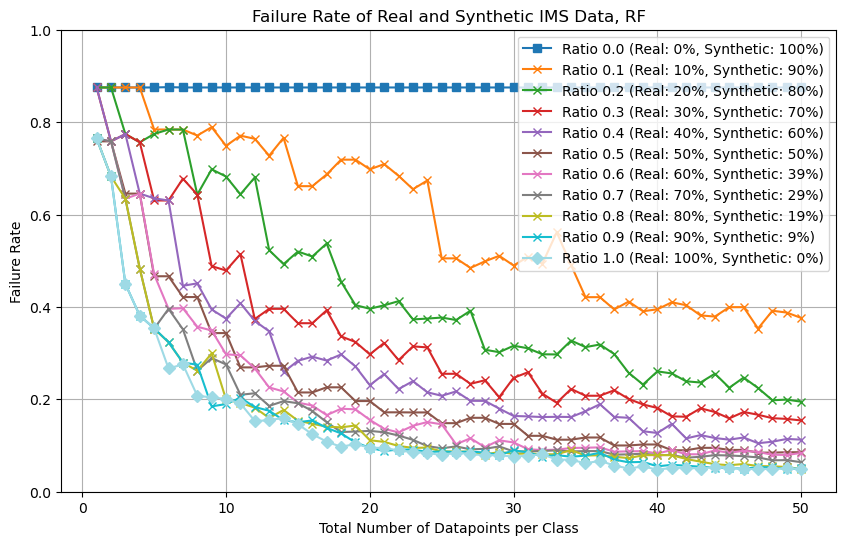

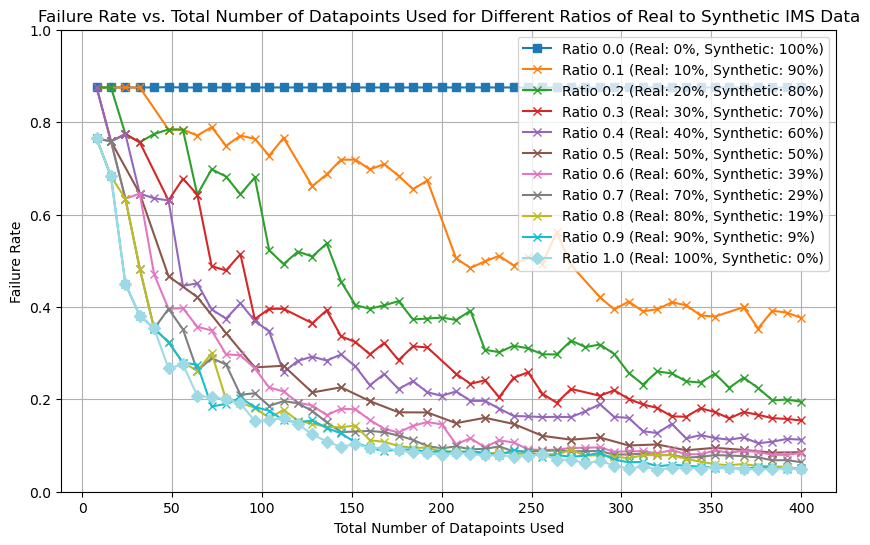

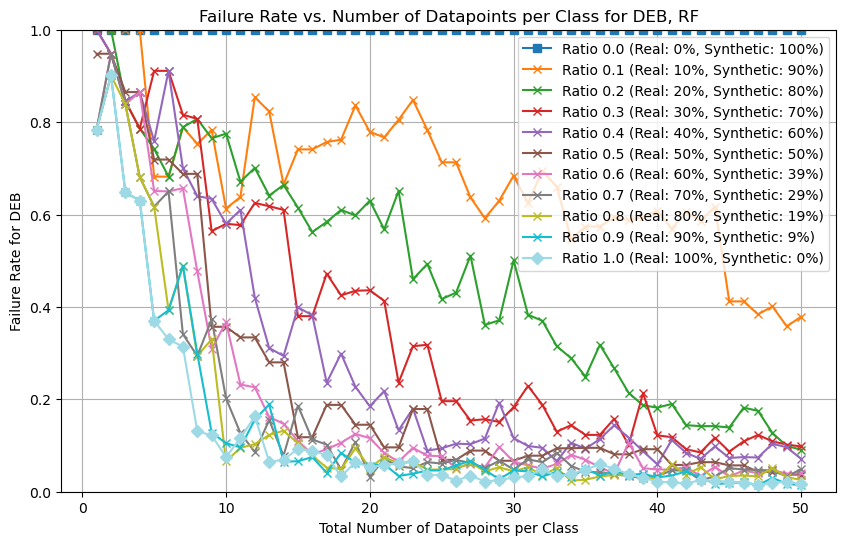

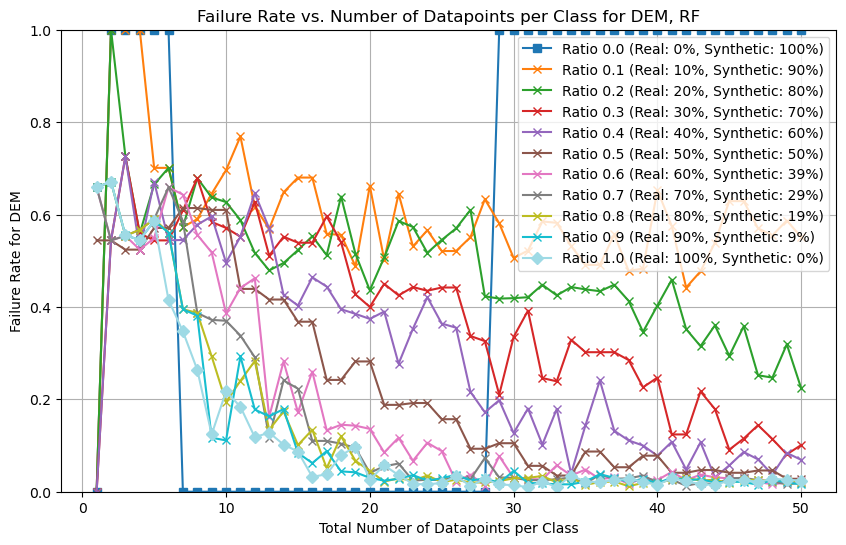

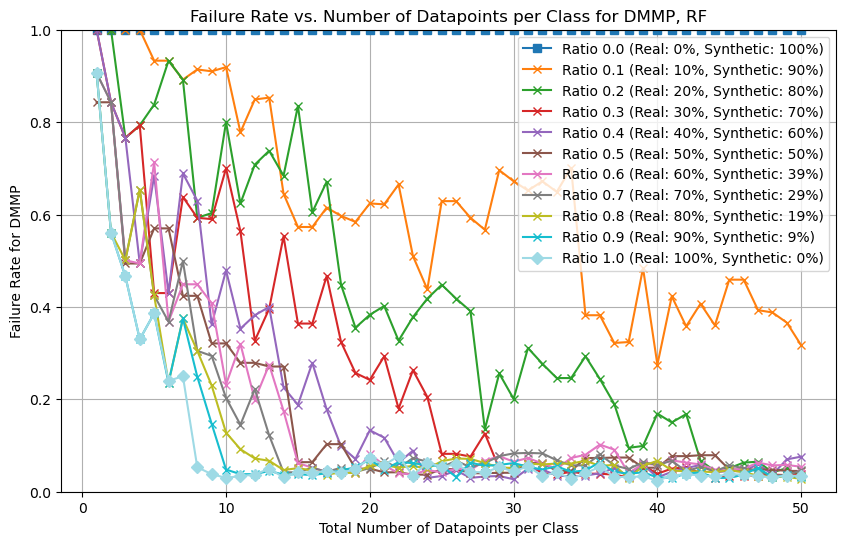

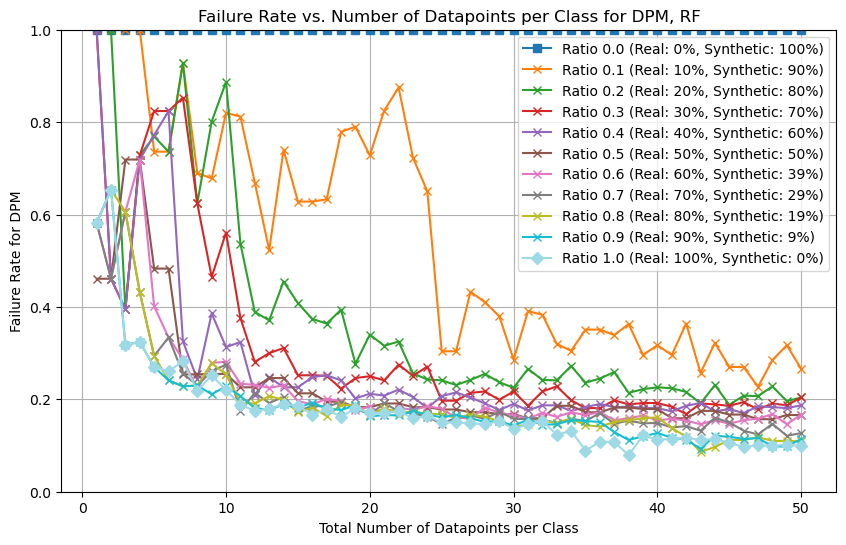

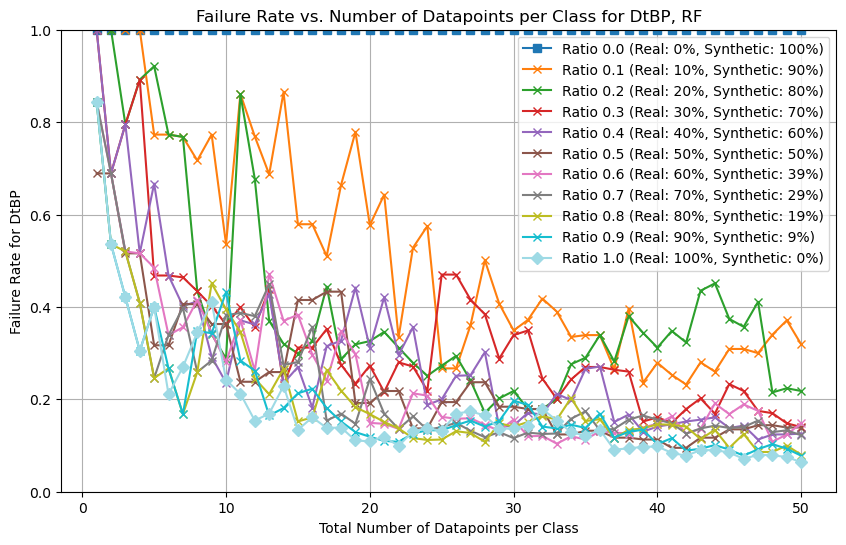

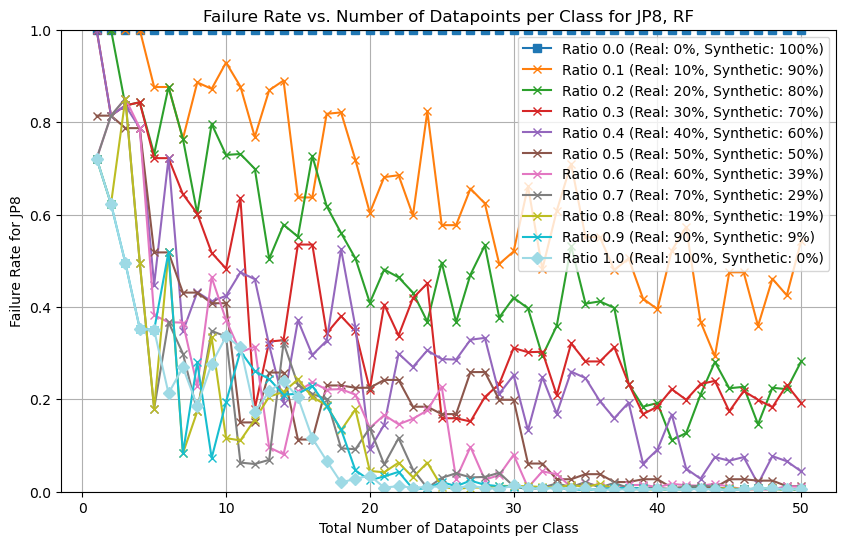

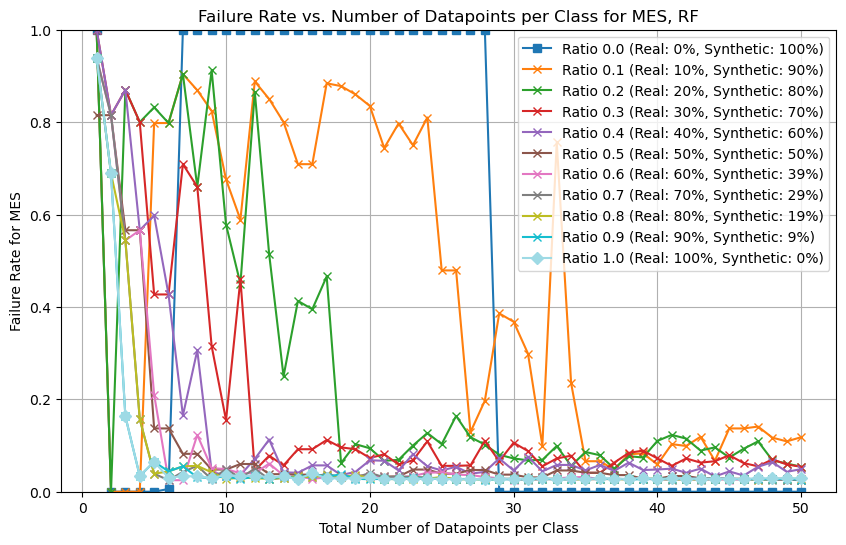

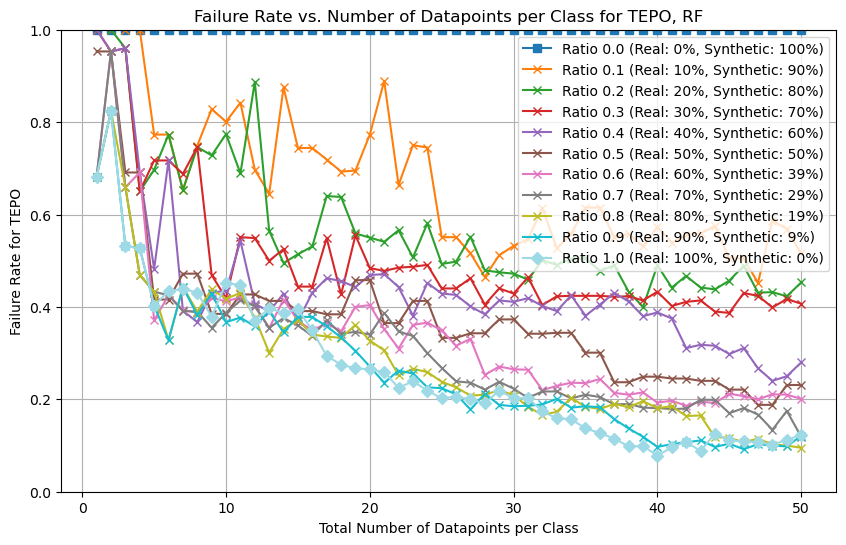

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to train and evaluate the random forest classifier
def train_and_evaluate_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

# Function to run the tests with different numbers of datapoints per class and ratios of real to synthetic data
def run_tests(real_data, synthetic_data, test_data, num_points_per_class, ratios):
    index = 0#random.randint(0, 1000)

    X_real, y_real = real_data.iloc[:, :-label_size].values, np.argmax(real_data.iloc[:, -label_size:].values, axis=1)
    X_synthetic, y_synthetic = synthetic_data.iloc[:, :-label_size].values, np.argmax(synthetic_data.iloc[:, -label_size:].values, axis=1)
    X_test, y_test = test_data.iloc[:, :-label_size].values, np.argmax(test_data.iloc[:, -label_size:].values, axis=1)
    
    results = []
    class_results = {class_label: [] for class_label in range(len(np.unique(y_test)))}
    
    for ratio in ratios:
        for num_points in num_points_per_class:
            X_train = []
            y_train = []
            
            for class_label in np.unique(y_real):
                real_indices = np.where(y_real == class_label)[0][index:int(num_points * ratio + 0.5)+index]
                synthetic_indices = np.where(y_synthetic == class_label)[0][index:int(num_points * (1 - ratio) + 0.5)+index]
                
                if len(real_indices) > 0:
                    X_train.append(X_real[real_indices])
                    y_train.append(y_real[real_indices])
                if len(synthetic_indices) > 0:    
                    X_train.append(X_synthetic[synthetic_indices])
                    y_train.append(y_synthetic[synthetic_indices])
            
            if len(X_train) > 0 and len(y_train) > 0:
                X_train = np.vstack(X_train)
                y_train = np.hstack(y_train)
                
                accuracy, y_pred = train_and_evaluate_rf(X_train, y_train, X_test, y_test)
                results.append((num_points, ratio, accuracy, len(X_train)))
                
                class_accuracies = class_wise_accuracy(y_test, y_pred, len(np.unique(y_test)))
                for class_label in range(len(np.unique(y_test))):
                    class_results[class_label].append((num_points, ratio, class_accuracies[class_label]))
    
    return results, class_results

# Function to calculate class-wise accuracy
def class_wise_accuracy(y_true, y_pred, num_classes):
    accuracies = []
    for class_label in range(num_classes):
        class_indices = np.where(y_true == class_label)[0]
        class_accuracy = accuracy_score(y_true[class_indices], y_pred[class_indices])
        accuracies.append(class_accuracy)
    return accuracies

# Define the number of datapoints per class to test and the ratios of real to synthetic data
num_points_per_class = np.arange(1, 51)  # 1 to 50
ratios = np.linspace(0, 1, 11)  # Ratios from 0 to 1 in steps of 0.1

# Run the tests
label_size = 8  # Assuming there are 8 label columns at the end of the dataframe
results, class_results = run_tests(train, train_data, testing, num_points_per_class, ratios)

# Extract the results
num_points, ratios, accuracies, num_datapoints = zip(*results)


# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate of Real and Synthetic IMS Data, RF')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

# Plot class-wise accuracies
for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}, RF')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()


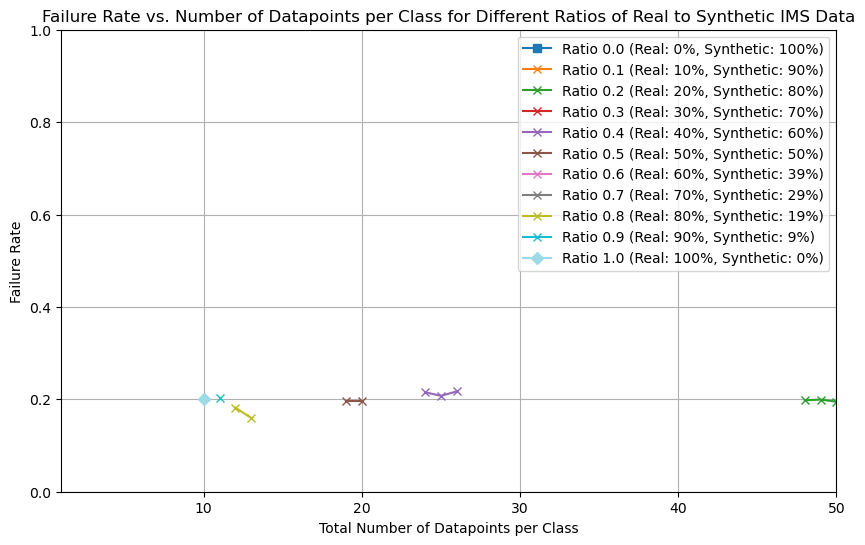

Overall Accuracy Data:
    Num Points  Failure Rate  Ratio
0           48      0.198000    0.2
1           49      0.199375    0.2
2           50      0.194875    0.2
3           24      0.215250    0.4
4           25      0.207625    0.4
5           26      0.217125    0.4
6           19      0.196250    0.5
7           20      0.196250    0.5
8           12      0.182000    0.8
9           13      0.159625    0.8
10          11      0.203250    0.9
11          10      0.200875    1.0


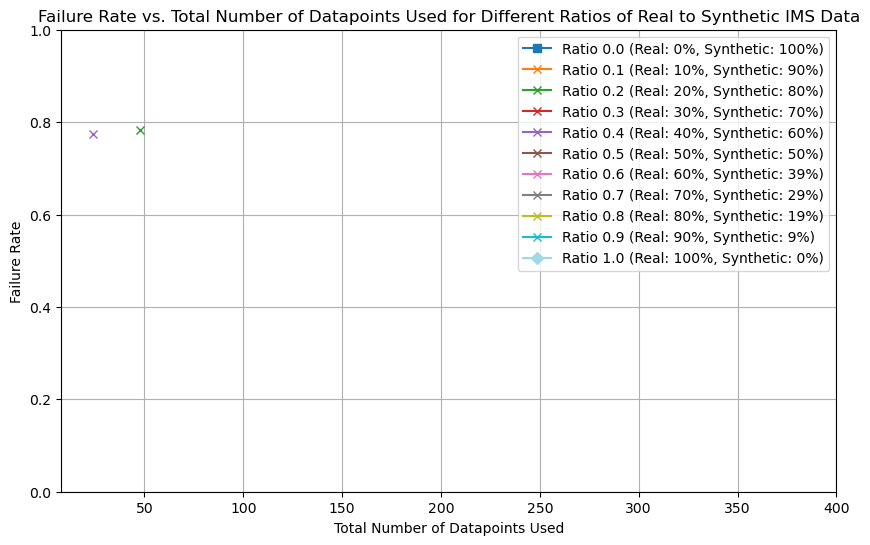

Datapoints Accuracy Data:
   Num Datapoints  Failure Rate  Ratio
0              48      0.784000    0.2
1              24      0.774125    0.4


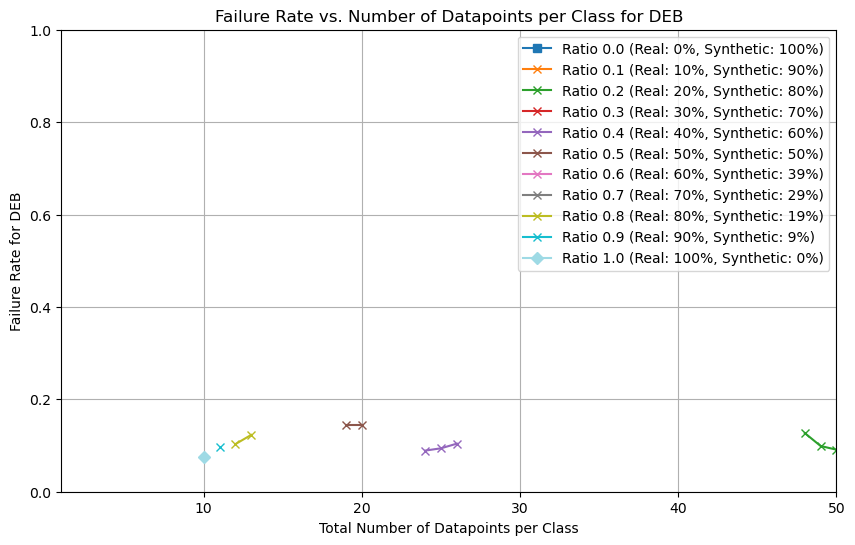

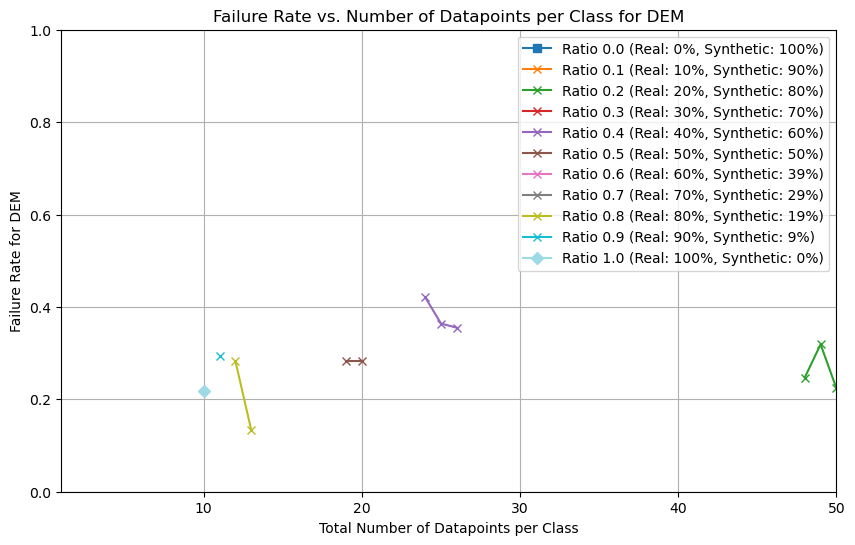

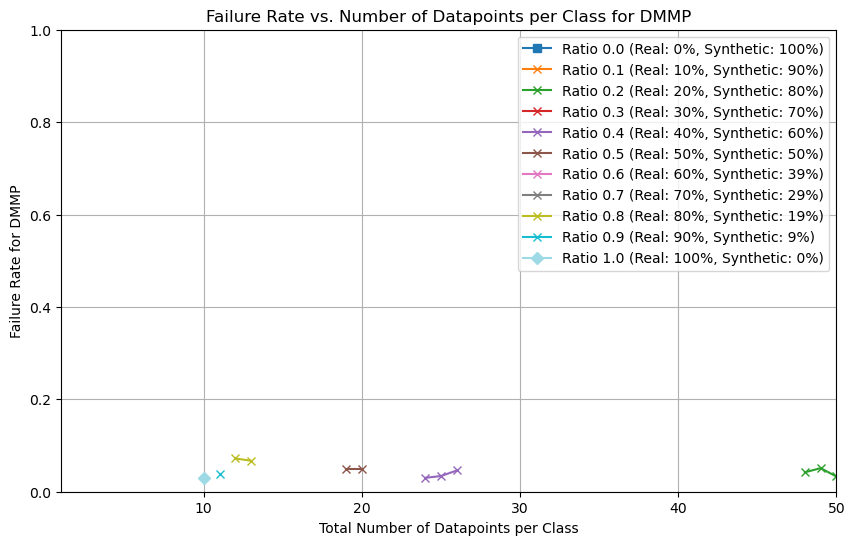

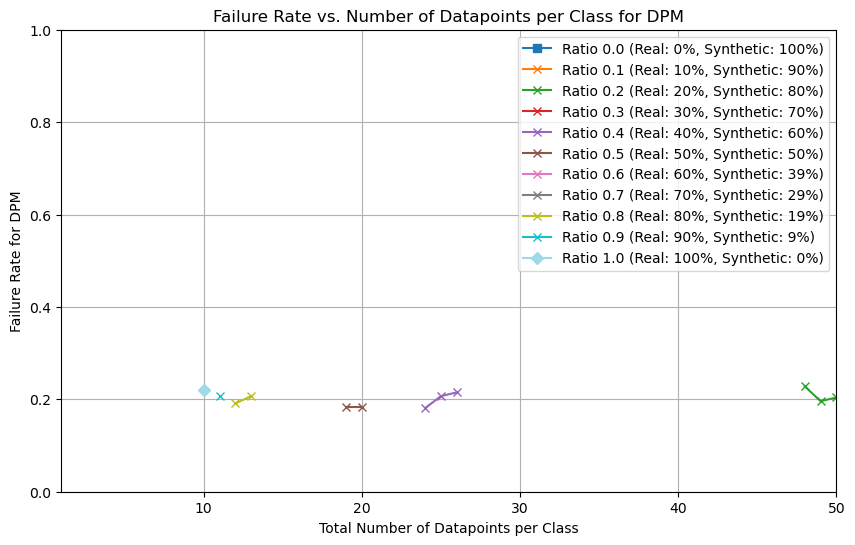

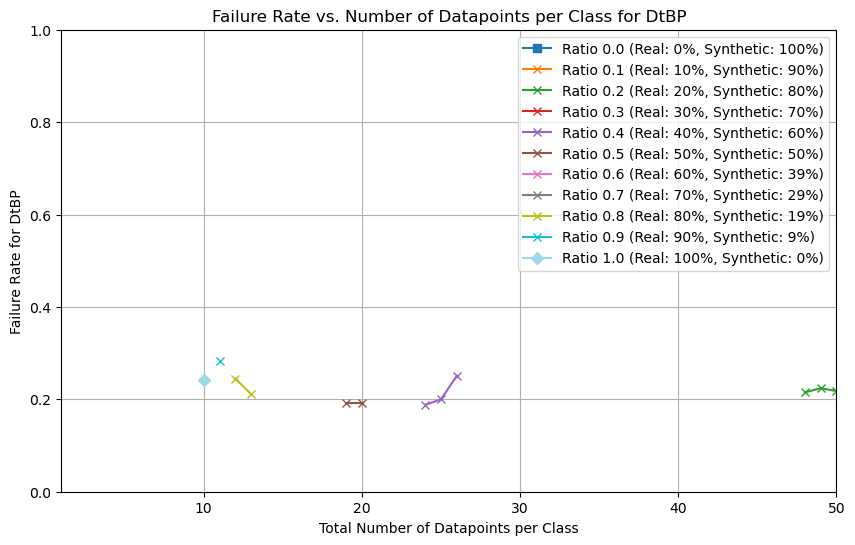

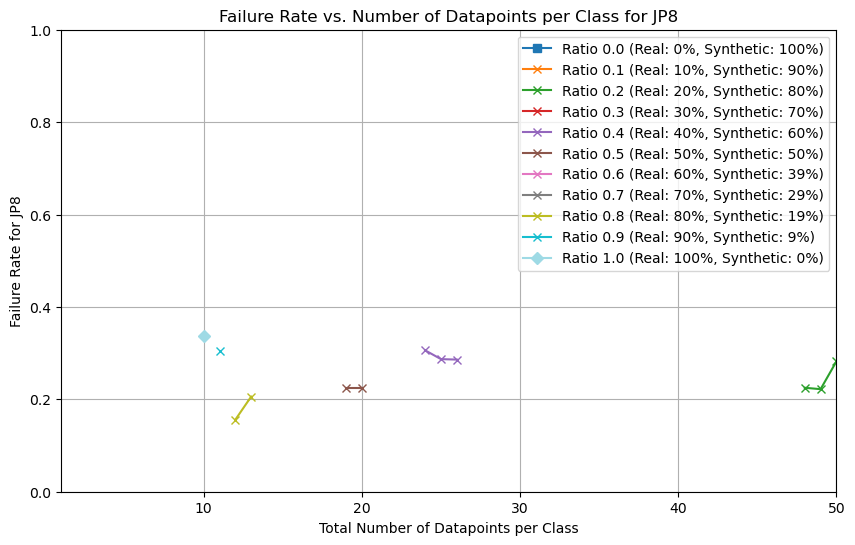

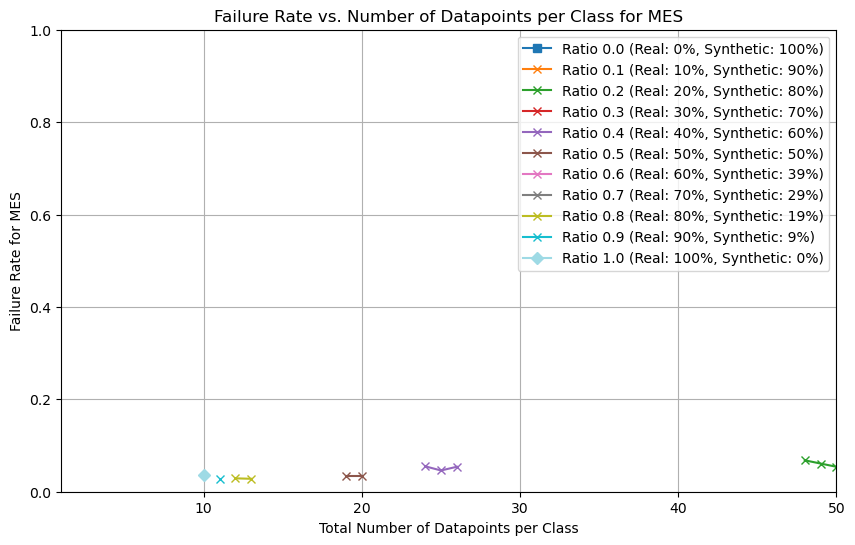

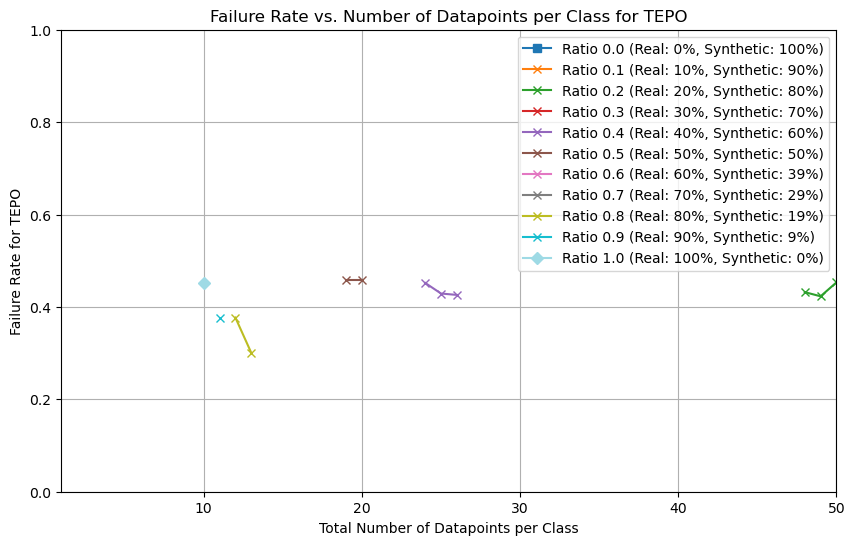

Class-wise Accuracy Data:
    Num Points  Failure Rate  Ratio Class
0           48         0.127    0.2   DEB
1           49         0.099    0.2   DEB
2           50         0.091    0.2   DEB
3           24         0.089    0.4   DEB
4           25         0.094    0.4   DEB
5           26         0.104    0.4   DEB
6           19         0.145    0.5   DEB
7           20         0.145    0.5   DEB
8           12         0.103    0.8   DEB
9           13         0.123    0.8   DEB
10          11         0.096    0.9   DEB
11          10         0.075    1.0   DEB
12          48         0.247    0.2   DEM
13          49         0.319    0.2   DEM
14          50         0.224    0.2   DEM
15          24         0.421    0.4   DEM
16          25         0.364    0.4   DEM
17          26         0.355    0.4   DEM
18          19         0.282    0.5   DEM
19          20         0.282    0.5   DEM
20          12         0.283    0.8   DEM
21          13         0.134    0.8   DEM
22      

In [ ]:
import pandas as pd

# Define the specific points to plot
specific_points = {
    1.0: [10],
    0.9: [11],
    0.8: [12, 13],
    0.7: [14],
    0.6: [16, 17],
    0.5: [19, 20],
    0.4: [24, 25, 26],
    0.3: [32, 33, 34],
    0.2: [48, 49, 50]
}

# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
overall_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_points)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    overall_data.append(pd.DataFrame({
        'Num Points': np.array(num_points)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Number of Datapoints per Class for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_points), max(num_points))
plt.ylim(0, 1)
plt.show()

# Combine overall data into a single DataFrame and display
overall_df = pd.concat(overall_data, ignore_index=True)
print("Overall Accuracy Data:")
print(overall_df)

plt.figure(figsize=(10, 6))
datapoints_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_datapoints)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    datapoints_data.append(pd.DataFrame({
        'Num Datapoints': np.array(num_datapoints)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_datapoints), max(num_datapoints))
plt.ylim(0, 1)
plt.show()

# Combine datapoints data into a single DataFrame and display
datapoints_df = pd.concat(datapoints_data, ignore_index=True)
print("Datapoints Accuracy Data:")
print(datapoints_df)

# Plot class-wise accuracies
class_data = []

for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        specific_mask = np.isin(np.array([result[0] for result in class_results[class_label]])[mask], specific_points.get(ratio, []))
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask][specific_mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
        class_data.append(pd.DataFrame({
            'Num Points': np.array([result[0] for result in class_results[class_label]])[mask][specific_mask],
            'Failure Rate': 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask],
            'Ratio': ratio,
            'Class': label_list[class_label]
        }))
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}')
    plt.legend()
    plt.grid(True)
    plt.xlim(min(num_points), max(num_points))
    plt.ylim(0, 1)
    plt.show()

# Combine class data into a single DataFrame and display
class_df = pd.concat(class_data, ignore_index=True)
print("Class-wise Accuracy Data:")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(class_df)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np

# Define a simple MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(128, output_dim)
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)
        return x

def train_mlp(X_train, y_train, X_test, y_test, num_classes, epochs=100, lr=0.001, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPClassifier(X_train.shape[1], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=min(batch_size, len(X_train)), shuffle=True)

    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y_test, predicted.cpu().numpy())
    return accuracy

def get_train_set(real_data, synthetic_data, num_real, num_synth, label_size, random_state=None):
    X_real, y_real = real_data.iloc[:, :-label_size].values, np.argmax(real_data.iloc[:, -label_size:].values, axis=1)
    X_synth, y_synth = synthetic_data.iloc[:, :-label_size].values, np.argmax(synthetic_data.iloc[:, -label_size:].values, axis=1)
    X_train, y_train = [], []
    rng = np.random.default_rng(random_state)
    for class_label in np.unique(y_real):
        real_indices_all = np.where(y_real == class_label)[0]
        synth_indices_all = np.where(y_synth == class_label)[0]
        if len(real_indices_all) >= num_real:
            real_indices = rng.choice(real_indices_all, num_real, replace=False)
            X_train.append(X_real[real_indices])
            y_train.append(y_real[real_indices])
        elif len(real_indices_all) > 0:
            real_indices = rng.choice(real_indices_all, len(real_indices_all), replace=False)
            X_train.append(X_real[real_indices])
            y_train.append(y_real[real_indices])
        if num_synth > 0 and len(synth_indices_all) >= num_synth:
            synth_indices = rng.choice(synth_indices_all, num_synth, replace=False)
            X_train.append(X_synth[synth_indices])
            y_train.append(y_synth[synth_indices])
        elif num_synth > 0 and len(synth_indices_all) > 0:
            synth_indices = rng.choice(synth_indices_all, len(synth_indices_all), replace=False)
            X_train.append(X_synth[synth_indices])
            y_train.append(y_synth[synth_indices])
    if len(X_train) > 0:
        X_train = np.vstack(X_train)
        y_train = np.hstack(y_train)
    return X_train, y_train

# Prepare test set
X_test = testing.iloc[:, :-label_size].values
y_test = np.argmax(testing.iloc[:, -label_size:].values, axis=1)

n_runs = 5
failures_10_0 = []
failures_10_40 = []
for run in range(n_runs):
    X_train1, y_train1 = get_train_set(train, train_data, 10, 0, label_size, random_state=run)
    acc1 = train_mlp(X_train1, y_train1, X_test, y_test, label_size)
    failures_10_0.append(1 - acc1)
    X_train2, y_train2 = get_train_set(train, train_data, 10, 40, label_size, random_state=run)
    acc2 = train_mlp(X_train2, y_train2, X_test, y_test, label_size)
    failures_10_40.append(1 - acc2)
    print(f"Run {run+1}: Failure Rate with 10 real, 00 synthetic per class: {1-acc1:.4f}")
    print(f"Run {run+1}: Failure Rate with 10 real, 40 synthetic per class: {1-acc2:.4f}")

print(f"\nMean ± Std Failure Rate with 10 real, 00 synthetic per class: {np.mean(failures_10_0):.4f} ± {np.std(failures_10_0):.4f}")
print(f"Mean ± Std Failure Rate with 10 real, 40 synthetic per class: {np.mean(failures_10_40):.4f} ± {np.std(failures_10_40):.4f}")
